In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import datetime
import google
google.colab.drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, previousSamples, futureSamples = 1, nodesPerLayer = 50, layers = 3, dropout_prob = 0.5):
        super(LSTMModel, self).__init__()
        self.layers = layers
        self.nodes = nodesPerLayer
        self.future = futureSamples
        self.prev = previousSamples
        self.lstm = nn.LSTM(1, nodesPerLayer, layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(nodesPerLayer, futureSamples)

    def forward(self, x):
        x = x.reshape(len(x), self.prev, 1)
        h0 = torch.zeros(self.layers, x.size(0), self.nodes,device=x.device).requires_grad_()
        c0 = torch.zeros(self.layers, x.size(0), self.nodes,device=x.device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)
        return out.reshape(len(out),1,self.future)

class GRUModel(nn.Module):
    def __init__(self, previousSamples, futureSamples = 1, nodesPerLayer = 20, layers = 2, dropout_prob = 0.3):
        super(GRUModel, self).__init__()
        self.layers = layers
        self.nodes = nodesPerLayer
        self.prev = previousSamples
        self.future = futureSamples
        self.gru = nn.GRU(1, nodesPerLayer, layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(nodesPerLayer, futureSamples)

    def forward(self, x):
        x = x.reshape(len(x), self.prev, 1)
        h0 = torch.zeros(self.layers, x.size(0), self.nodes,device=x.device).requires_grad_()
        out, _ = self.gru(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)
        return out.reshape(len(out),1,self.future)

class CNNModel(nn.Module):
    def __init__(self, previousSamples, futureSamples = 1, kernel = 2):
        super(CNNModel, self).__init__()
        self.future = futureSamples
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=3, kernel_size=2),  # 1D convolutional layer
            nn.ReLU(),
            nn.BatchNorm1d(3),
            nn.Conv1d(in_channels=3, out_channels=2, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(2),
            nn.Flatten(),  # Flatten the output for fully connected layers
            nn.Linear(2 * (previousSamples - 1), 50),  # Adjust the input size based on your sequence length
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Linear(50, futureSamples)
        )
    def forward(self, x):
        x = self.cnn(x)
        return x.reshape(len(x),1,self.future)


class LinearModel(nn.Module):
    def __init__(self, previousSamples, futureSamples = 1):
        super(LinearModel, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(previousSamples, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, futureSamples)
        )
    def forward(self, x):
        x = self.linear(x)
        return x


def readLatency():
    #returns sampling frequency, scales latency to ms and converts time stamps to a difference from first time stamp that is HH:MM:SS = 00:00:00.
    #puts the resulting timeseries in a pandas dataframe, to be used by prophet
    timeseries = list()
    dataFrame = pd.read_parquet("/content/drive/My Drive/LatencyData/data.parquet")
    Fs = 1/(dataFrame["packet_interval"][0]*10**(-9)) #Sampling frequency, 1/(sampling period) where sampling period is given in ns
    dataFrame = dataFrame[["timestamps.client.send.wall", "timestamps.server.receive.wall"]]
    y = (dataFrame["timestamps.server.receive.wall"] - dataFrame["timestamps.client.send.wall"])*10**(-9)*10**3 #measured in ns, converted to ms
    y = y.to_numpy()
    return y[1000:], Fs #Drop first 1000 samples to remove transients at measurement start


def subSample(timeseries, windowLength):
    means = list()
    N = len(timeseries)
    windows = N//windowLength
    windowStartIdx = 0
    for windowIdx in range(windows):
        window = timeseries[windowStartIdx:windowStartIdx+windowLength]
        means.append(window.mean())
        windowStartIdx += windowLength
    return np.array(means)

def plotTimeseries(timeseries):
    plt.plot(timeseries)
    plt.xlabel('Index')
    plt.ylabel('Latency [ms]')
    plt.grid(True)
    plt.show()

def readCSV():
    timeseries = list()
    dataFrame = pd.read_csv("/content/drive/My Drive/LatencyData/w15r5.csv")
    y = dataFrame["0"]
    y = y.to_numpy()
    return y[200:] #Drop first 1000 samples  for w15, subsampled by factor 5 -> drop 200 first for w15r5

def splitTimeseries(timeseries, partition):
    timeseries1 = timeseries[:int(len(timeseries)*partition)]
    timeseries2 = timeseries[int(len(timeseries)*partition):]
    return timeseries1, timeseries2

def preProcess(timeseries, normalize = False):
    #timeseries = timeseries[timeseries < 20] #Remove outliers
    trainTempTimeseries, testTimeseries = splitTimeseries(timeseries, 0.8)
    trainTimeseries, validationTimeseries = splitTimeseries(trainTempTimeseries, 0.8)

    if normalize:
        trainMean = trainTimeseries.mean()
        trainStd = trainTimeseries.std()
        #Normalize with training (!) statistics
        trainTimeseries = (trainTimeseries - trainMean)/trainStd
        validationTimeseries = (validationTimeseries - trainMean)/trainStd
        testTimeseries = (testTimeseries - trainMean)/trainStd

    return trainTimeseries, validationTimeseries, testTimeseries

def createDataset(timeseries, previousSamples, futureSamples, where):
    X, y = [], []
    for i in range(len(timeseries)-previousSamples-futureSamples):
        feature = timeseries[i:i+previousSamples]
        target = timeseries[i+previousSamples:i+previousSamples+futureSamples]
        X.append(feature)
        y.append(target)
    X = torch.tensor(np.array(X), dtype=torch.float)
    y = torch.tensor(np.array(y), dtype=torch.float)
    return X[:, None, :].to(where), y[:, None, :].to(where)

def calculateTime(start, stop):
    totalTimeDiff = stop - start
    totalDiffSeconds = int(totalTimeDiff.total_seconds())
    TotalDiffMinuteSeconds, seconds = divmod(totalDiffSeconds, 60)
    hours, minutes = divmod(TotalDiffMinuteSeconds, 60)
    #return f"{hours}h {minutes}m {seconds}s"
    return f"{minutes}m {seconds}s"

def trainModel(model, XTrain, yTrain, XVal, yVal, previousSamples, futureSamples):
    startTime = datetime.datetime.now()
    optimizer = optim.Adam(model.parameters())
    lossFunction = nn.MSELoss()
    dataLoader = data.DataLoader(data.TensorDataset(XTrain, yTrain), shuffle=False, batch_size=16)
    XTrain = XTrain.to("cpu")
    yTrain = yTrain.to("cpu")
    trainingEpochs = 50
    bestValRMSE = 500
    for epoch in range(trainingEpochs):
        model.train()
        for XBatch, yBatch in dataLoader:
            yHat = model(XBatch)
            loss = lossFunction(yHat, yBatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 1 == 0: #Can be adjusted to train more or less
            model.eval()
            model.cpu()
            with torch.no_grad():
                yHat = model(XTrain)
                trainRMSE = np.sqrt(lossFunction(yHat, yTrain))
                yHat = model(XVal)
                valRMSE = np.sqrt(lossFunction(yHat, yVal))
                print("Training Epoch: ", epoch+1, "    train RMSE: ", trainRMSE.item(), "    validation RMSE: ", valRMSE.item())
                if valRMSE < bestValRMSE:
                    bestModelTime = datetime.datetime.now()
                    bestValRMSE = valRMSE
                    torch.save(model, "/content/drive/My Drive/GRUSubSampled/11.pth")
                else:
                    #When validation loss do not decrease - stop.
                    #This might be a bit early, however it minimize required training time and the performance loss is not substantial
                    break
            model.to(device)
    stopTime = datetime.datetime.now()
    print("Total training time / time for best found model: ", calculateTime(startTime, stopTime),  " / ", calculateTime(startTime, bestModelTime))
    return model

def DisplayPerformance(model, XTest, yTest):
    if model == None:
        model = torch.load("/content/drive/My Drive/GRUSubSampled/11.pth")
    model.eval()
    model.cpu()
    lossFunction = nn.MSELoss()
    with torch.no_grad():
        yHat = model(XTest)
        yHatNP = torch.flatten(yHat).detach().cpu().numpy()
        yTestNP = torch.flatten(yTest).detach().cpu().numpy()
        MAPE = np.sum(np.abs((yHatNP-yTestNP)/yTestNP))/len(yTestNP)
        print("Test MAPE: ", 100*MAPE, "%")
        yHatFNP = torch.flatten(yHat[:, :, 0]).detach().cpu().numpy()
        yTestFNP = torch.flatten(yTest[:, :, 0]).detach().cpu().numpy()
        MAPEF = np.sum(np.abs((yHatFNP-yTestFNP)/yTestFNP))/len(yTestFNP)
        print("Test MAPE first future sample: ", 100*MAPEF, "%")
        yHatNNP = torch.flatten(yHat[:, :, -1]).detach().cpu().numpy()
        yTestNNP = torch.flatten(yTest[:, :, -1]).detach().cpu().numpy()
        MAPEN = np.sum(np.abs((yHatNNP-yTestNNP)/yTestNNP))/len(yTestNNP)
        print("Test MAPE N-th future sample: ", 100*MAPEN, "%")

    plt.plot(yTest[:, : , 0].reshape(-1)[:200], label= "y")
    plt.plot(yHat[:, : , 0].reshape(-1)[:200], label = "yHat")
    plt.xlabel('Test sample')
    plt.ylabel('Latency [ms]')
    plt.legend()
    plt.show()

Training Epoch:  1     train RMSE:  5.6463823318481445     validation RMSE:  5.383053302764893
Training Epoch:  2     train RMSE:  5.6464409828186035     validation RMSE:  5.383086204528809
Total training time / time for best found model:  0m 27s  /  0m 13s
Test MAPE:  23.00331007293138 %
Test MAPE first future sample:  23.002415285281987 %
Test MAPE N-th future sample:  22.98645557891672 %


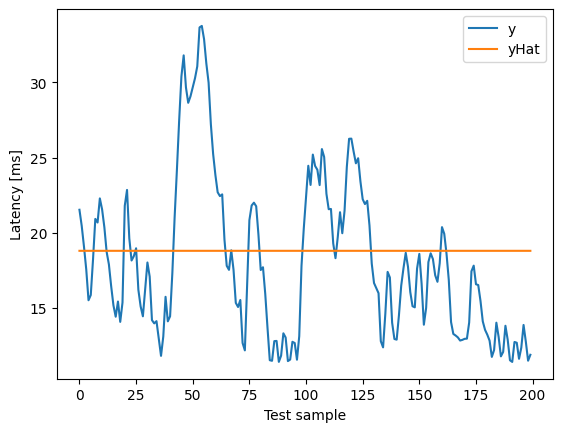

In [ ]:
#Use measurement from session 13 with lowest outlier percentage
#timeseries, Fs = readLatency()
#timeseries = subSample(timeseries, 182) #each sample now is average latency for a second of measurements
#plotTimeseries(timeseries)
timeseries = readCSV() #reads window 15 rate 5 (w15r5) or window 15 (w15) (no subsampling!)
trainTimeseries, validationTimeseries, testTimeseries = preProcess(timeseries)
previousSamples = 10
futureSamples = 50
#model = CNNModel(previousSamples, futureSamples)
#model = LinearModel(previousSamples, futureSamples)
model = GRUModel(previousSamples, futureSamples, nodesPerLayer = 60, layers = 1, dropout_prob = 0).to(device)
#model = LSTMModel(previousSamples, futureSamples, nodesPerLayer = 50, layers = 1, dropout_prob = 0).to(device)
XTrain, yTrain = createDataset(trainTimeseries, previousSamples, futureSamples, device)
XVal, yVal = createDataset(validationTimeseries, previousSamples, futureSamples, "cpu")
XTest, yTest = createDataset(testTimeseries, previousSamples, futureSamples, "cpu")
model = trainModel(model, XTrain, yTrain, XVal, yVal, previousSamples, futureSamples)
DisplayPerformance(None, XTest, yTest)